In [8]:
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "06_preprocessing/06d_augmentation.ipynb"
_nb_title = "Data Augmentation: Geometric Transformations"

### no need to change any of this
_nb_safeloc = _nb_loc.replace('/', '%2F')
md("""
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name={1}&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F{2}&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F{2}">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>
""".format(_nb_loc, _nb_title, _nb_safeloc))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Data Augmentation: Geometric Transformations&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F06_preprocessing%2F06d_augmentation.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F06_preprocessing%2F06d_augmentation.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/06d_augmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/06_preprocessing/06d_augmentation.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/06_preprocessing/06d_augmentation.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Data Augmentation: Geometric Transformations

In this notebook, we carry out data augmentation to improve the model's resilience and accuracy

## Enable GPU and set up helper functions

This notebook and pretty much every other notebook in this repository
will run faster if you are using a GPU.
On Colab:
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
- Navigate to https://console.cloud.google.com/ai-platform/notebooks
- Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


## Preprocessor

This class contains preprocessing functions that have to be explicitly applied between training and prediction.

In [1]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [2]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 448 # note *twice* what we used to have
IMG_WIDTH = 448
IMG_CHANNELS = 3
CLASS_NAMES = 'daisy dandelion roses sunflowers tulips'.split()

class _Preprocessor:    
    def __init__(self):
        # nothing to initialize
        pass
    
    def read_from_tfr(self, proto):
        feature_description = {
            'image': tf.io.VarLenFeature(tf.float32),
            'shape': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature([], tf.string, default_value=''),
            'label_int': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        }
        rec = tf.io.parse_single_example(
            proto, feature_description
        )
        shape = tf.sparse.to_dense(rec['shape'])
        img = tf.reshape(tf.sparse.to_dense(rec['image']), shape)
        label_int = rec['label_int']
        return img, label_int
    
    def read_from_jpegfile(self, filename):
        # same code as in 05_create_dataset/jpeg_to_tfrecord.py
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
      
    def preprocess(self, img):
        return tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH)
    
def create_preproc_dataset(pattern):
    preproc = _Preprocessor()
    trainds = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(pattern)],
        compression_type='GZIP'
    ).map(preproc.read_from_tfr).map(
        lambda img, label: (preproc.preprocess(img), label))                             
    return trainds

def create_preproc_image(filename):
    preproc = _Preprocessor()
    img = preproc.read_from_jpegfile(filename)
    return preproc.preprocess(img)    

## Transfer Learning with MobileNet

With random cropping & left-right flipping

In [4]:
import tensorflow_hub as hub
import os
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'    

#PATTERN_SUFFIX='-0000*'
#NUM_EPOCHS=3

PATTERN_SUFFIX='-*'
NUM_EPOCHS=20

# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       l1 = 0.,
                       l2 = 0.,
                       num_hidden = 16):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    
    train_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/train' + PATTERN_SUFFIX
    ).batch(batch_size)
    eval_dataset = create_preproc_dataset(
        'gs://practical-ml-vision-book-data/flowers_tfr/valid' + PATTERN_SUFFIX
    ).batch(batch_size)

    layers = [
      tf.keras.layers.experimental.preprocessing.RandomCrop(
          height=IMG_HEIGHT//2, width=IMG_WIDTH//2,
          input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
          name='random/center_crop'
      ),
      tf.keras.layers.experimental.preprocessing.RandomFlip(
          mode='horizontal',
          name='random_lr_flip/none'
      ),
      hub.KerasLayer(
          "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
          trainable=False,
          name='mobilenet_embedding'),
      tf.keras.layers.Dense(num_hidden,
                            kernel_regularizer=regularizer, 
                            activation=tf.keras.activations.relu,
                            name='dense_hidden'),
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
    ]

    model = tf.keras.Sequential(layers, name='flower_classification')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
    print(model.summary())
    history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
    training_plot(['loss', 'accuracy'], history)
    return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random/center_crop (RandomCr (None, 224, 224, 3)       0         
_________________________________________________________________
random_lr_flip/none (RandomF (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_embedding (KerasLa (None, 1280)              2257984   
_________________________________________________________________
dense_hidden (Dense)         (None, 16)                20496     
_________________________________________________________________
flower_prob (Dense)          (None, 5)                 85        
Total params: 2,278,565
Trainable params: 20,581
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/20
90/90 [==============================] - 156s 2s/step - loss: 1.4726 - accuracy:

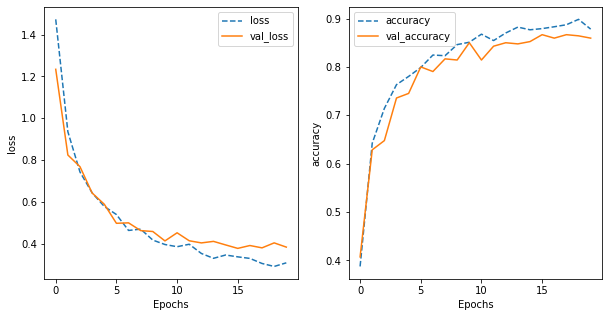

In [5]:
model = train_and_evaluate()

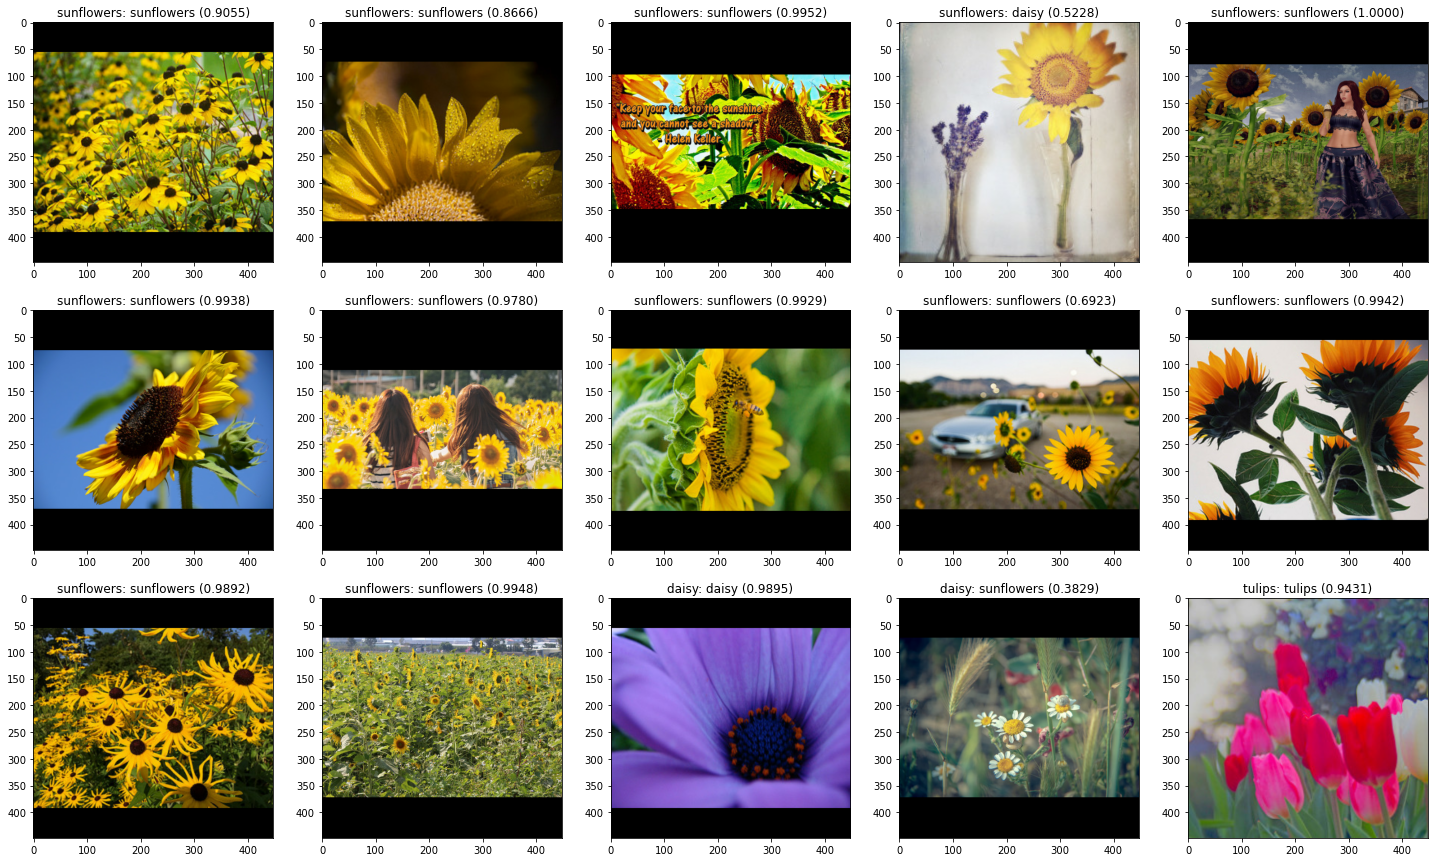

In [6]:
# Call model.predict() on a few images in evaluation dataset
def plot_predictions(model, pattern):
    dataset = create_preproc_dataset(pattern)
    f, ax = plt.subplots(3, 5, figsize=(25,15))
    for idx, (img, label) in enumerate(dataset.take(15)):
        ax[idx//5, idx%5].imshow((img.numpy()));
        batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
        batch_pred = model.predict(batch_image)
        pred = batch_pred[0]
        label = CLASS_NAMES[label.numpy()]
        pred_label_index = tf.math.argmax(pred).numpy()
        pred_label = CLASS_NAMES[pred_label_index]
        prob = pred[pred_label_index]
        ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

plot_predictions(model, 'gs://practical-ml-vision-book-data/flowers_tfr/valid-*')

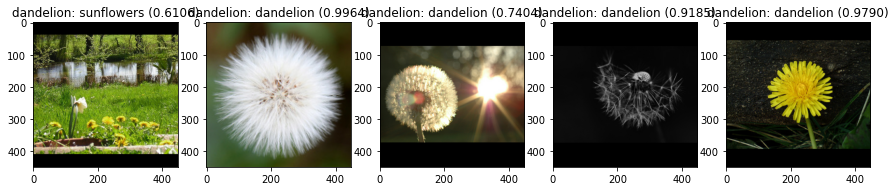

In [7]:
## but actually, for prediction, we won't have TensorFlow Records.
## this is how we'd predict for individual images
## (actually, we'll create a serving function: we'll look at that in a later chapter)
filenames = [
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/98992760_53ed1d26a9.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9939430464_5f5861ebab.jpg',
    'gs://practical-ml-vision-book-data/flowers_5_jpeg/flower_photos/dandelion/9965757055_ff01b5ee6f_n.jpg'
]
label = 'dandelion'
input_images = [create_preproc_image(f) for f in filenames]
f, ax = plt.subplots(1, 5, figsize=(15,15))
for idx, img in enumerate(input_images):
    ax[idx].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

## License
Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.